### Imports

In [3]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tarfile

In [19]:
MAIN_DIR_PATH = os.getcwd()
DATA_DIR_PATH = os.path.join(MAIN_DIR_PATH, 'data')
TAR_FILE_PATH = os.path.join(DATA_DIR_PATH, 'ES_fut_chain.tar')
EXTRACT_PATH = os.path.join(DATA_DIR_PATH, 'extracts')

In [6]:
ALL_DATA_FILES = []

with tarfile.open(TAR_FILE_PATH, 'r') as tar:
    for member in tar.getmembers():
        if member.isfile():
            ALL_DATA_FILES.append(member.name)

ALL_DATA_FILES.sort()

### Util functions

In [21]:
def read_data_from_tar(file_name, tar_path=TAR_FILE_PATH, extract_path=EXTRACT_PATH):
    with tarfile.open(tar_path, 'r') as tar:
        tar.extract(file_name, path=extract_path)
    
    df = pd.read_parquet(os.path.join(extract_path, file_name))
        
    return df

def read_multiple(num_files, tar_path=TAR_FILE_PATH, extract_path=EXTRACT_PATH):
    data_list = [read_data_from_tar(file_name,
                                    tar_path=tar_path,
                                    extract_path=extract_path) 
                                        for file_name in ALL_DATA_FILES[:num_files]]

    return pd.concat(data_list)


def dir_empty(dir_path):
    return len(os.listdir(dir_path)) == 0

def clean_extracts(extract_path=EXTRACT_PATH):
    shutil.rmtree(extract_path)

### Data sanity check

It appears that the columns are non-null.

In [14]:
# data_list = [read_data_from_tar(file_name) for file_name in ALL_DATA_FILES[:1_000]]

df = read_data_from_tar(ALL_DATA_FILES[0])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype                           
---  ------  --------------  -----                           
 0   index   7009 non-null   datetime64[ns, America/New_York]
 1   bid     7009 non-null   float64                         
 2   bidQ    7009 non-null   float64                         
 3   ask     7009 non-null   float64                         
 4   askQ    7009 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(4)
memory usage: 273.9 KB


In [20]:
df.head(10)

,index,bid,bidQ,ask,askQ
0,1997-09-09 11:30:03.299999-04:00,335.118182,18.0,335.387353,33.0
1,1997-09-09 11:30:03.659999-04:00,335.118182,17.0,335.387353,33.0
2,1997-09-09 11:30:04.810000-04:00,335.118182,47.0,335.387353,33.0
3,1997-09-09 11:30:06.889999-04:00,335.118182,47.0,335.387353,63.0
4,1997-09-09 11:30:09.499999-04:00,335.118182,47.0,335.387353,62.0
5,1997-09-09 11:30:09.759999-04:00,335.118182,47.0,335.387353,33.0
6,1997-09-09 11:30:14.050000-04:00,335.118182,47.0,335.387353,32.0
7,1997-09-09 11:30:15.829999-04:00,335.118182,47.0,335.297630,12.0
8,1997-09-09 11:30:20.730000-04:00,335.118182,46.0,335.297630,12.0
9,1997-09-09 11:30:21.530000-04:00,335.118182,46.0,335.297630,32.0


### Plots

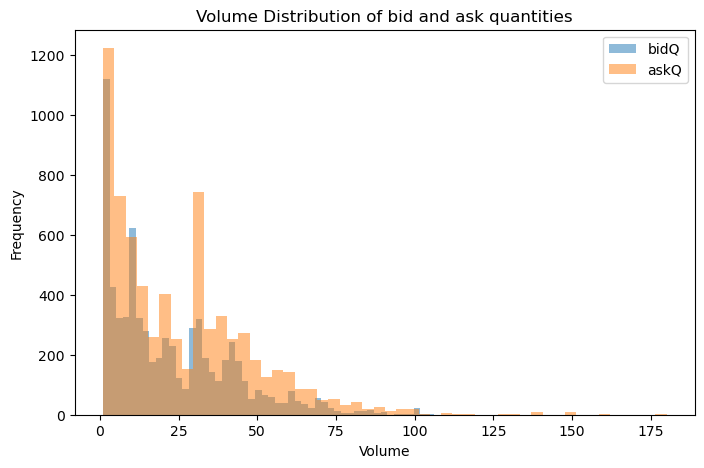

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(df['bidQ'], bins=50, alpha=0.5, label='bidQ')
plt.hist(df['askQ'], bins=50, alpha=0.5, label='askQ')
plt.legend(loc='upper right')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Volume Distribution of bid and ask quantities')
plt.show();

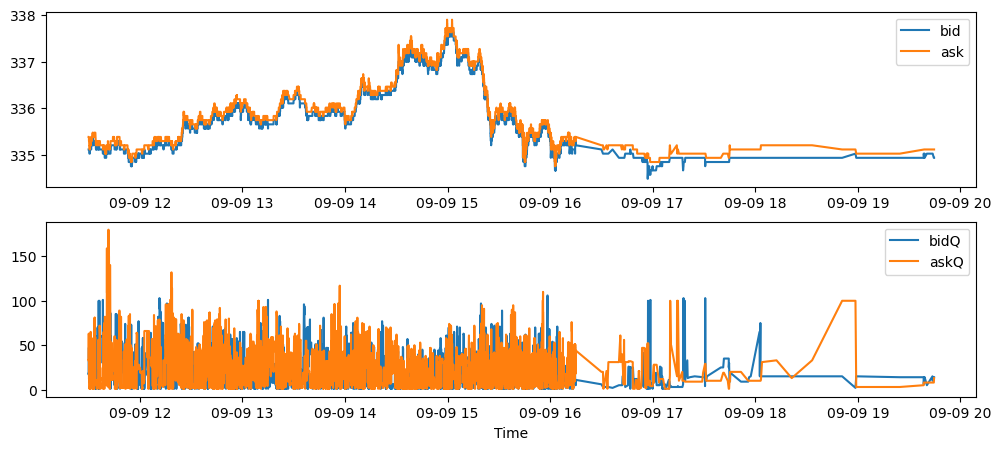

In [18]:
x_axis = df['index']

fig, ax = plt.subplots(nrows=2, figsize=(12, 5))

ax[0].plot(x_axis, df['bid'], label='bid')
ax[0].plot(x_axis, df['ask'], label='ask')
# ax[0].ylabel('Price')
ax[0].legend()

ax[1].plot(x_axis, df['bidQ'], label='bidQ')
ax[1].plot(x_axis, df['askQ'], label='askQ')
# ax[1].ylabel('Volume')
ax[1].legend()

plt.xlabel('Time')
# plt.plot(df['index'], df['bid'], label='bidQ')
# plt.plot(df['bid'], label='bid')
plt.show();